# 借助geopandasOD将OD数据集计到行政区划，并绘制OD期望线
data:

GIS文件：
1.深圳行政区划
2.深圳栅格

数据：
1.出租车GPS集计栅格OD

In [1]:
#导入必要的包
import pandas as pd
import numpy as np

#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas包
import geopandas

#shapely包
from shapely.geometry import Point,Polygon,shape


C:\Program Files\Python37\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


　geopandas是建立在GEOS、GDAL、PROJ等开源地理空间计算相关框架之上的，类似pandas语法风格的空间数据分析Python库，其目标是尽可能地简化Python中的地理空间数据处理，减少对Arcgis、PostGIS等工具的依赖，使得处理地理空间数据变得更加高效简洁，打造纯Python式的空间数据处理工作流。  

<img src="dataframe.png">  

The core data structure in GeoPandas is the geopandas.GeoDataFrame, a subclass of pandas.DataFrame, that can store geometry columns and perform spatial operations. The geopandas.GeoSeries, a subclass of pandas.Series, handles the geometries. Therefore, your GeoDataFrame is a combination of pandas.Series, with traditional data (numerical, boolean, text etc.), and geopandas.GeoSeries, with geometries (points, polygons etc.). You can have as many columns with geometries as you wish; there’s no limit typical for desktop GIS software.



### 1.读取基础数据
#### 1.1 GIS数据

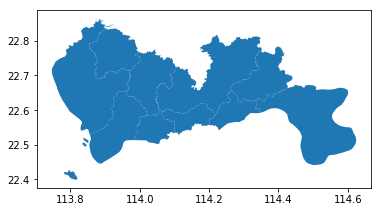

In [2]:
#行政区划数据
#读取shapefile文件
shp = r'shapefile\sz.shp'
xzqh = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')  #使用geopandas对shp文件进行处理

#绘制看看长什么样
xzqh.plot()

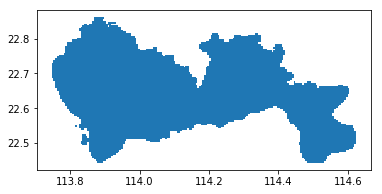

In [3]:
#栅格数据
#读取shapefile文件
shp = r'shapefile\grid\grid.shp'
grid = geopandas.GeoDataFrame.from_file(shp,encoding = 'gbk')

#绘制看看长什么样
grid.plot()

#### 1.2 栅格OD数据
这个数据是前面教程2中，用公式计算出来的OD

In [4]:
OD = pd.read_csv(r'data-sample\taxi_od_grid.csv')
OD.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum
0,63,17,65,16,298
1,75,21,74,19,275
2,63,18,65,16,235
3,76,21,74,19,173
4,65,17,63,18,172


### 2.栅格与小区、行政区的匹配
#### 2.1栅格中心点获取

In [5]:
#栅格所带的字段信息
grid.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,54,113.749504,22.688405,"POLYGON ((113.74707 22.68616, 113.74707 22.690..."
1,0,55,113.749504,22.692902,"POLYGON ((113.74707 22.69065, 113.74707 22.695..."
2,0,56,113.749504,22.697399,"POLYGON ((113.74707 22.69515, 113.74707 22.699..."
3,0,57,113.749504,22.701895,"POLYGON ((113.74707 22.69965, 113.74707 22.704..."
4,0,58,113.749504,22.706392,"POLYGON ((113.74707 22.70414, 113.74707 22.708..."


我们现在要做的是，将栅格与行政区匹配，希望得到的是，在栅格信息的后面加一列，表示这个栅格属于哪个行政区划

在这里，我们考虑以栅格中心点落在哪个空间单元来判断，比如某栅格中心点落在宝安区，那么认为这个栅格是宝安区的栅格

因此，下一步我们定义一个geoDataFrame变量，命名为grid_point，存储的是栅格的中心点

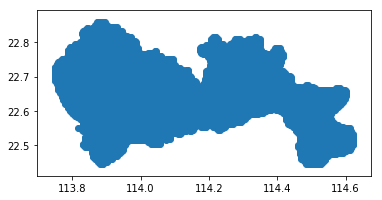

In [6]:
grid_point = grid.copy()
#我们相当于把geometry这一列的信息由polygon改成point
grid_point['geometry'] = grid.centroid    #centroid返回每个几何对象的重心（几何中心）

grid_point.plot()

In [7]:
grid_point.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,54,113.749504,22.688405,POINT (113.74950 22.68841)
1,0,55,113.749504,22.692902,POINT (113.74950 22.69290)
2,0,56,113.749504,22.697399,POINT (113.74950 22.69740)
3,0,57,113.749504,22.701895,POINT (113.74950 22.70190)
4,0,58,113.749504,22.706392,POINT (113.74950 22.70639)


#### 2.2空间连接sjoin
在对栅格和行政区划连接时，要用到geopandas的sjoin方法

In [8]:
#连接到行政区划
grid_point = geopandas.sjoin(grid_point, xzqh, how="inner", op='intersects')
grid_point.head(5)

C:\Program Files\Python37\lib\site-packages\IPython\core\interactiveshell.py:3254: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,LONCOL,LATCOL,HBLON,HBLAT,geometry,index_right,centroid_x,centroid_y,qh
2,0,56,113.749504,22.697399,POINT (113.74950 22.69740),3,113.851387,22.67912,宝安
3,0,57,113.749504,22.701895,POINT (113.74950 22.70190),3,113.851387,22.67912,宝安
4,0,58,113.749504,22.706392,POINT (113.74950 22.70639),3,113.851387,22.67912,宝安
5,0,59,113.749504,22.710888,POINT (113.74950 22.71089),3,113.851387,22.67912,宝安
6,0,60,113.749504,22.715385,POINT (113.74950 22.71539),3,113.851387,22.67912,宝安


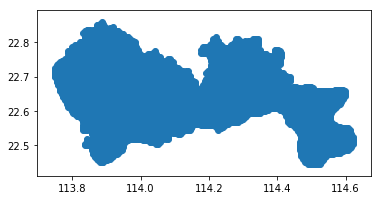

In [9]:
grid_point.plot()

In [10]:
#只取我们要的列
grid_point = grid_point[['LONCOL','LATCOL','qh','centroid_x','centroid_y']]

#### 2.3把OD表的起点终点和grid_point表连接
这里我们用df.merge，把OD和grid_point表连接起来

In [11]:
grid_point.columns = ['SLONCOL','SLATCOL','Sqh','S_x','S_y']
OD = pd.merge(OD,grid_point,on = ['SLONCOL','SLATCOL'])
grid_point.columns = ['ELONCOL','ELATCOL','Eqh','E_x','E_y']
OD = pd.merge(OD,grid_point,on = ['ELONCOL','ELATCOL'])

OD.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,Sqh,S_x,S_y,Eqh,E_x,E_y
0,63,17,65,16,298,福田,114.041535,22.546180,福田,114.041535,22.54618
1,75,21,65,16,139,罗湖,114.143157,22.577605,福田,114.041535,22.54618
2,63,18,65,16,235,福田,114.041535,22.546180,福田,114.041535,22.54618
3,76,21,65,16,89,罗湖,114.143157,22.577605,福田,114.041535,22.54618
4,65,17,65,16,64,福田,114.041535,22.546180,福田,114.041535,22.54618


#### 2.4集计行政区划的OD

In [12]:
#集计
OD = OD.groupby(['Sqh','S_x','S_y','Eqh','E_x','E_y'])['VehicleNum'].sum().reset_index()

OD.head(5)

,Sqh,S_x,S_y,Eqh,E_x,E_y,VehicleNum
0,光明,113.92629,22.766157,光明,113.926290,22.766157,141
1,光明,113.92629,22.766157,南山,113.930714,22.544103,8
2,光明,113.92629,22.766157,宝安,113.851387,22.679120,119
3,光明,113.92629,22.766157,福田,114.041535,22.546180,3
4,光明,113.92629,22.766157,罗湖,114.143157,22.577605,2


只保留跨行政区的出行，即Sqh与Eqh相等的就不要了

In [13]:
OD = OD[-(OD['Sqh']==OD['Eqh'])]
OD.head(5)

,Sqh,S_x,S_y,Eqh,E_x,E_y,VehicleNum
1,光明,113.92629,22.766157,南山,113.930714,22.544103,8
2,光明,113.92629,22.766157,宝安,113.851387,22.679120,119
3,光明,113.92629,22.766157,福田,114.041535,22.546180,3
4,光明,113.92629,22.766157,罗湖,114.143157,22.577605,2
5,光明,113.92629,22.766157,龙华,114.029687,22.686910,57


### 3. OD的绘制

In [14]:
#画期望线的时候，我们希望小的先画，大的后画，这样大的OD就会在最上面

OD = OD.sort_values(by = 'VehicleNum')
OD.head(5)

,Sqh,S_x,S_y,Eqh,E_x,E_y,VehicleNum
30,大鹏,114.502205,22.571337,龙岗,114.206790,22.695694,1
26,大鹏,114.502205,22.571337,宝安,113.851387,22.679120,1
24,大鹏,114.502205,22.571337,坪山,114.356936,22.691020,1
21,坪山,114.356936,22.691020,罗湖,114.143157,22.577605,1
19,坪山,114.356936,22.691020,宝安,113.851387,22.679120,1


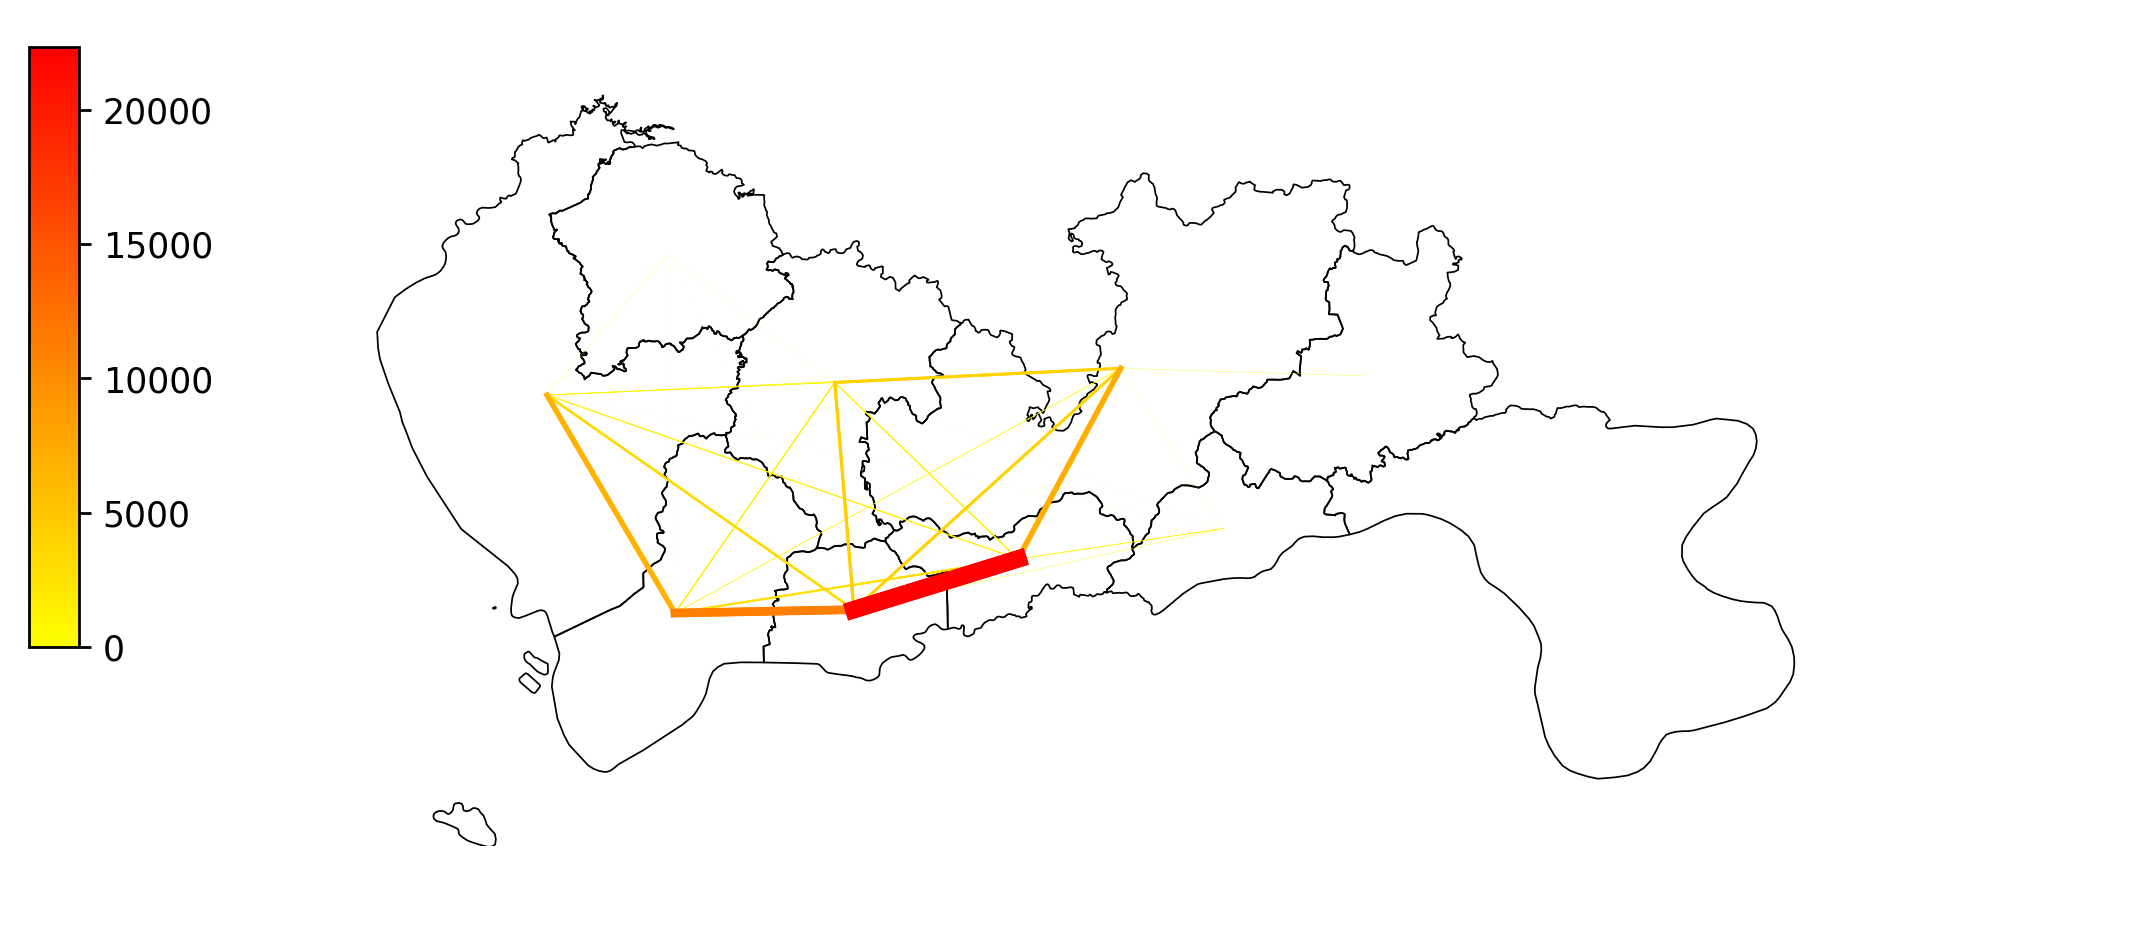

In [15]:
#导入绘图包
import matplotlib as mpl
import matplotlib.pyplot as plt


fig   = plt.figure(1,(10,8),dpi = 250)    
ax    = plt.subplot(111)
plt.sca(ax)

#绘制行政区划
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

#设置colormap的数据
import matplotlib
vmax = OD['VehicleNum'].max()
#设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#设定colormap的颜色
cmapname = 'autumn_r'
#cmap是一个获取颜色的工具，cmap(a)会返回颜色，其中a是0-1之间的值
cmap = matplotlib.cm.get_cmap(cmapname)

#绘制OD
for i in range(len(OD)):
    #设定第i条线的color和linewidth
    color_i=cmap(norm(OD['VehicleNum'].iloc[i]))
    linewidth_i=norm(OD['VehicleNum'].iloc[i])*5
    
    #绘制
    plt.plot([OD['S_x'].iloc[i],OD['E_x'].iloc[i]],[OD['S_y'].iloc[i],OD['E_y'].iloc[i]],color=color_i,linewidth=linewidth_i)


    
#不显示坐标轴
plt.axis('off')    

#绘制假的colorbar，这是因为，我们画的OD是线，没办法直接画出来colorbar
#所以我们在一个看不见的地方画了一个叫imshow的东西，他的范围是0到vmax
#然后我们再对imshow添加colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

#然后要把镜头调整回到深圳地图那，不然镜头就在imshow那里了

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)


plt.show()

用plot_map包绘制底图
小旭学长自制plot_map包，可为专题图添加背景底图

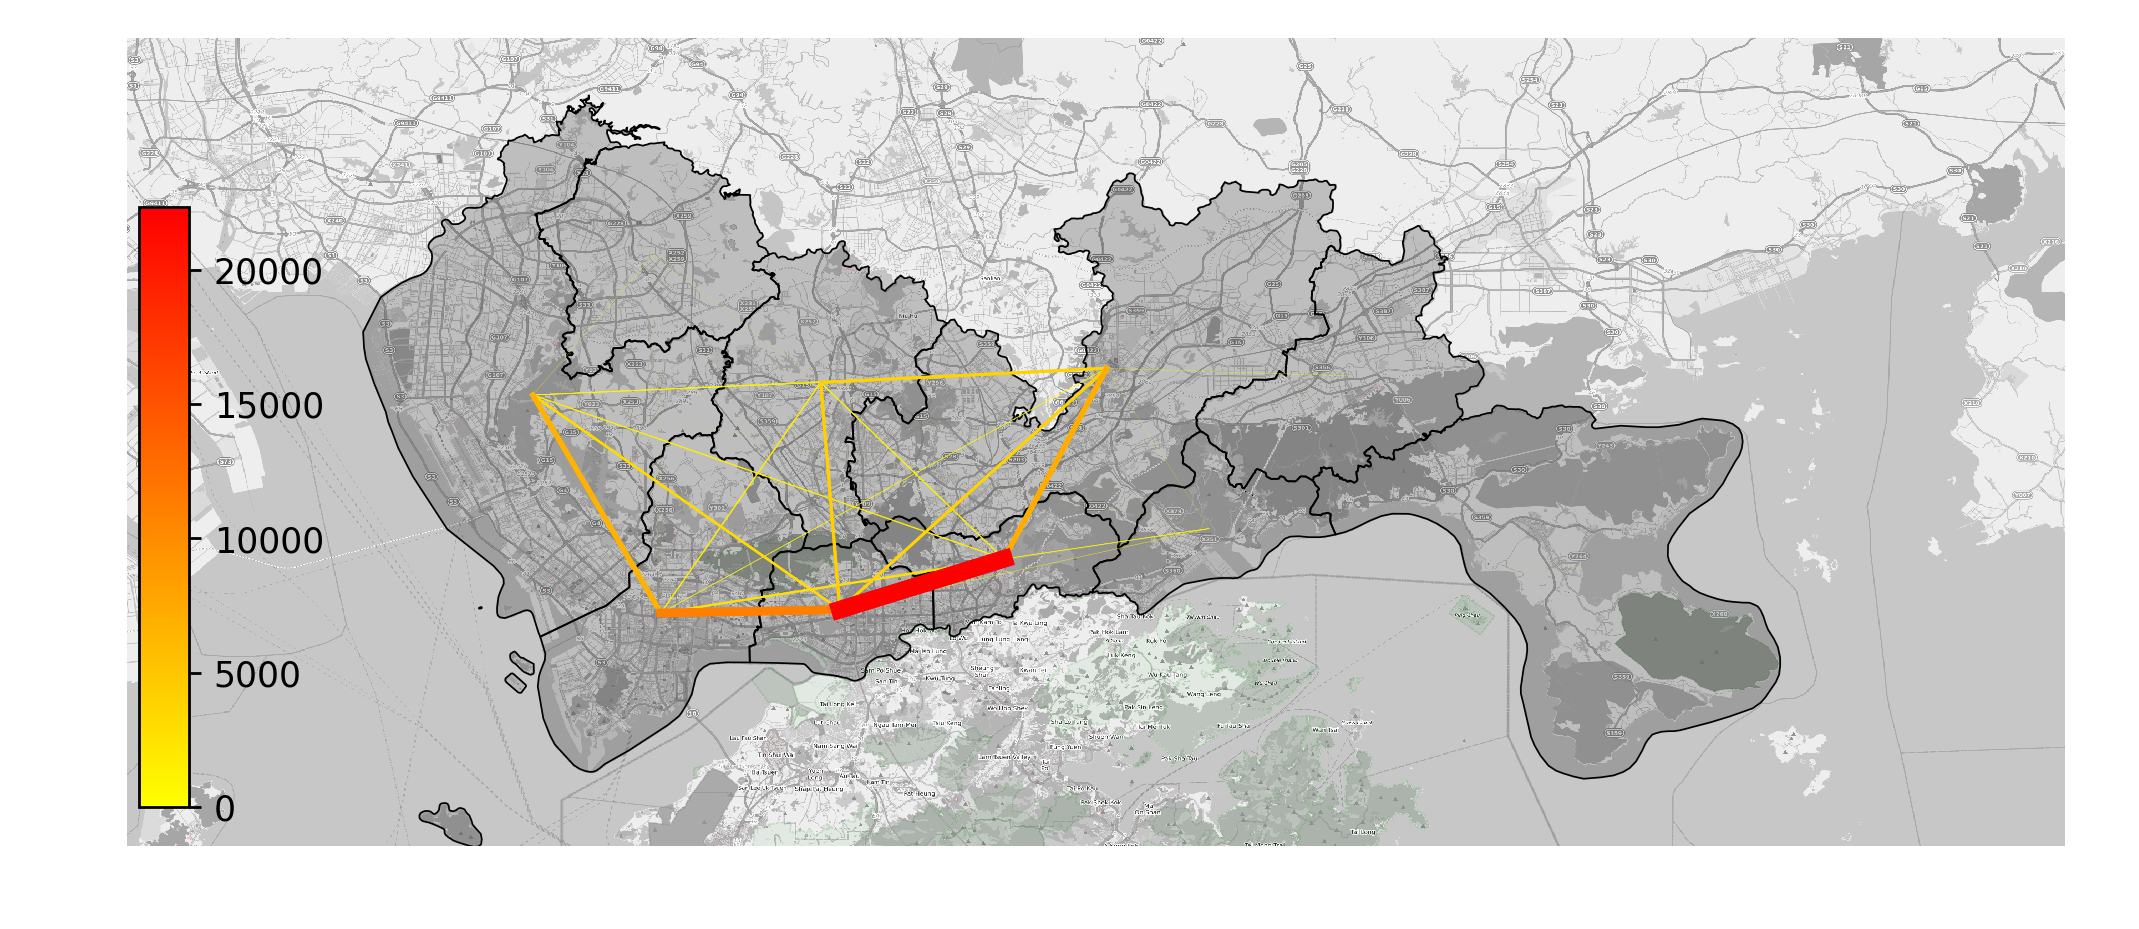

In [18]:
import plot_map

fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

bounds = [113.6,22.4,114.8,22.9]
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#绘制行政区划
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.2),linewidths=0.5)

#设置colormap的数据
import matplotlib
vmax = OD['VehicleNum'].max()
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)

#绘制OD
for i in range(len(OD)):
    color_i=cmap(norm(OD['VehicleNum'].iloc[i]))
    linewidth_i=norm(OD['VehicleNum'].iloc[i])*5
    plt.plot([OD['S_x'].iloc[i],OD['E_x'].iloc[i]],[OD['S_y'].iloc[i],OD['E_y'].iloc[i]],color=color_i,linewidth=linewidth_i)


    
#不显示坐标轴
plt.axis('off')    

#添加colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)


plt.show()